In [1]:
import sys
sys.path.insert( 0, '../')
import ness
import rxnet

In [2]:
import numpy as np

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update( {'font.size':20})

## Dimer pharmacokinetics

I will consider a drug molecule that acts as a homodimer and constructs a detailed model of its pharmacokinetics.  The molecule, $L$, dimerizes before it can bind to its target $R$.  The corresponding reactions are:

$L + L \underset{k_1}{\stackrel{k_2}{\rightleftharpoons}} L_2$

$L_2 + R \underset{k_d}{\stackrel{k_a}{\rightleftharpoons}} RL_2$

Supose that this is an intracellular target.  The molecule has to first permeate through the membrane to get into the cell.  Denoting the extracellular molecule as $L_e$:

$L_e \underset{\beta}{\stackrel{\alpha}{\rightleftharpoons}} L$

The extracellular molecules are cleared out by metabolism:

$L_e \stackrel{\gamma}{\rightarrow} \varnothing$ 

Let $\vec{x} = ( L_e, L, L_2, R, RL_2 )^t$, the reaction stoichiometry matrix is 

### Pharmacokinetic constants

The permeability constant $P$ is defined by $dQ/dt = P C_e A$, where $Q$ is the quantity of permeated molecules, $C_e$ is the concentration on the source side of the membrane (the extracellular side), and $A$ is the surface area of permeable membrane (cell surface area $A = 4\pi r^2$).  Dividing both sides by the cell volume $V = 4\pi r^3/3$, we have 

$\alpha = \beta = C_e^{-1} \frac{dC_i}{dt} = P A/V = 3 P/r$ 

Cell radius, in cm (because permeability is often given in cm/s)

In [4]:
rcell = 2e-3 

The good, moderate, and poor permeability

In [5]:
perms = dict( good = 1.e-5,
              okay = 2.e-8,
              poor = 1.e-9 )
alphas = dict( [(v, 3*p/rcell) for v, p in perms.items()])
alphas

{'good': 0.015000000000000001,
 'okay': 3.0000000000000004e-05,
 'poor': 1.5000000000000002e-06}

The elimination rate constant, assuming a half-life of 0.5 hour, is

In [6]:
hour = 3600 # seconds in hour
gamma = np.log(2)/(0.5*hour)
gamma

0.0003850817669777474

### Good permeability, moderate affinity, moderate dimerization

In [7]:
ks = dict( k2=1.e2, k1=2.e1,
           ka=1.e2, kd=1.e2,
           alpha=alphas['good'], beta=alphas['good'],
           gamma=gamma)

In [8]:
krx = np.array( [ [ ks['k2'], ks['k1']],
                  [ ks['ka'], ks['kd']],
                  [ ks['alpha'], ks['beta']],
                  [ ks['gamma'], 0.] ])

One can use the utility provided by rxnet.py to construct the reaction stiochiometry matrix.

In [9]:
rxs = [ 'L + L = L2',  # Can also be written as '2*L = L2'
        'L2 + R = RL2',
        'Le = L',
        'Le = E']

In [10]:
Crx, mols = rxnet.reactionMatrix( rxs)

In [11]:
Crx

array([[ 2., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1., -1.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.]])

In [12]:
mols

['L', 'L2', 'R', 'RL2', 'Le', 'E']

In [13]:
R0 = 0.25
x0 = np.array( [0., 0, R0, 0, 1, 0])
tmax = 10 # hours
xt = ness.kinetics( Crx, krx, x0, tmax*hour)

In [14]:
def set_yaxis_color( ax, color, side='left'):
    ax.spines[side].set_color( color)
    ax.tick_params(axis='y', colors=color)
    ax.yaxis.label.set_color( color)
    
def plot_pharmacokinetics( xt, active, plasma, threshold=0.05*R0):
    colors = ['#8da0cb','#fc8d62','#66c2a5']
    fig, ax = plt.subplots()
    times = xt.t/hour
    ax.plot( times, xt.y[active], color=colors[0])
    ax.plot( (np.min(times), np.max(times)), (threshold, threshold), '--', color=colors[0])
    ax.set_ylim( 0, 0.05)
    ax2 = ax.twinx()
    ax2.plot( times, xt.y[plasma], '-', color=colors[1])
    # ax.set_xscale( 'log')
    ax.set_xlabel( 'Time (hours)')
    ax.set_ylabel( 'Activity')
    ax2.set_ylim( 1e-3, 2)
    ax2.set_yscale( 'log')
    ax2.set_ylabel( 'Plasma concentration')
    set_yaxis_color( ax, colors[0])
    set_yaxis_color( ax2, colors[1], 'right')
    return fig

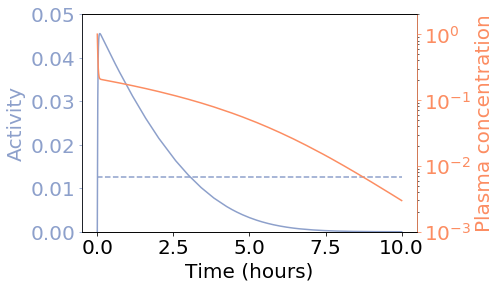

In [15]:
figD = plot_pharmacokinetics( xt, mols.index('RL2'), mols.index('Le'))

In [16]:
figD.savefig( 'figures/dimer.eps', bbox_inches='tight')

## Monomer pharmacokinetics

Let's now consider a monomeric drug.

In [17]:
rxsM = [ 'L + R = RL',
        'Le = L',
        'Le = E' ]

In [18]:
CrxM, molsM = rxnet.reactionMatrix( rxsM)

In [19]:
molsM

['L', 'R', 'RL', 'Le', 'E']

### Strong binding, moderate permeability

Consider a drug with higher affinity but moderate permeability

In [20]:
ksM = dict( ka = 1.e2, kd = 1.e1,
            alpha = alphas['okay'], beta = alphas['okay'],
            gamma = gamma)
krxM = np.array( [ 
             [ksM['ka'], ksM['kd']],
             [ksM['alpha'], ksM['beta']],
             [ksM['gamma'], 0.]])

In [21]:
x0M = np.array( [ 0., R0, 0., 1., 0])
xtM = ness.kinetics( CrxM, krxM, x0M, tmax*hour)

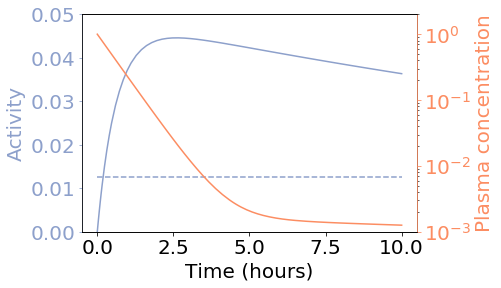

In [22]:
figM = plot_pharmacokinetics( xtM, molsM.index('RL'), molsM.index('Le'))

In [23]:
figM.savefig( 'figures/okay-permeability.eps', bbox_inches='tight')

### Strong binding, poor permeability

Consider a drug with strong affinity but poor permeability

In [24]:
ksMp = dict( ka = 1.e2, kd = 1.,
            alpha = alphas['poor'], beta = alphas['poor'],
            gamma = gamma)
krxMp = np.array( [ 
             [ksMp['ka'], ksMp['kd']],
             [ksMp['alpha'], ksMp['beta']],
             [ksMp['gamma'], 0.]])

In [25]:
xtMp = ness.kinetics( CrxM, krxMp, x0M, tmax*hour)

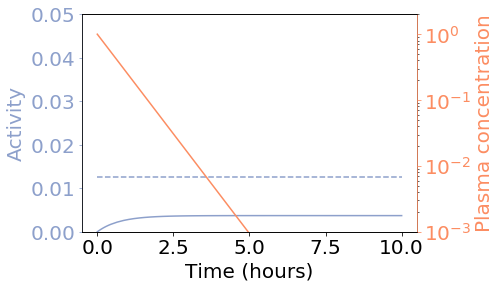

In [26]:
figMp = plot_pharmacokinetics( xtMp, molsM.index('RL'), molsM.index('Le'))

In [27]:
figMp.savefig( 'figures/poor-permeability.eps', bbox_inches='tight')